In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp2d,interpn,interp1d,RectBivariateSpline

### Air Source Heat Pump Experimentation
The goal of this notebook is to model the heating energy usage of a building throughout an average winter, and understand how an air source heat pump would operate in this environment.

1. In this notebook we build up weather bin data over a 40 year history in New Rochelle NY.
2. Given the building design parameters (gleaned from a Manual-J report), we estimate the distribution of building loads over air temperature.
3. We also model the performance, in terms of capacity and output of the upcoming SpacePak SIS-060A inverter driven split system.

### Load 1 hour weather bars

In [2]:
weather = pd.read_csv('./data/b68ae80c504c3736013cee0375a19681.csv')
weather['timestamp']=pd.to_datetime(weather['dt']*1000000000.0).dt.tz_localize('utc').dt.tz_convert('America/New_York')
weather['date']=weather['timestamp'].dt.date
weather['year']=weather['timestamp'].dt.year
weather['month']=weather['timestamp'].dt.month
weather['time']=weather['timestamp'].dt.time
weather['month_cat']=weather['month'].astype('category')
weather=weather.query('year<2020').copy()
weather=weather.merge(weather.groupby('date')['temp'].min().to_frame('min_daily_temp'), on='date')
weather=weather.merge(weather.groupby('date')['temp'].max().to_frame('max_daily_temp'), on='date')
weather['outside_temp']=weather['temp'].round()
weather['is_heating_day']=1.0*((weather['min_daily_temp']<50)&(~weather['month'].isin([6,7,8,9]))&(weather['max_daily_temp']<71))
weather['is_cooling_day']=1.0*((1.0-weather['is_heating_day']).astype(bool)&(weather['month'].isin([6,7,8,9]))&(weather['min_daily_temp']>50))

heating_day = weather.query('is_heating_day==1.0').copy()
cooling_day = weather.query('is_cooling_day==1.0').copy()


### View of the weather data

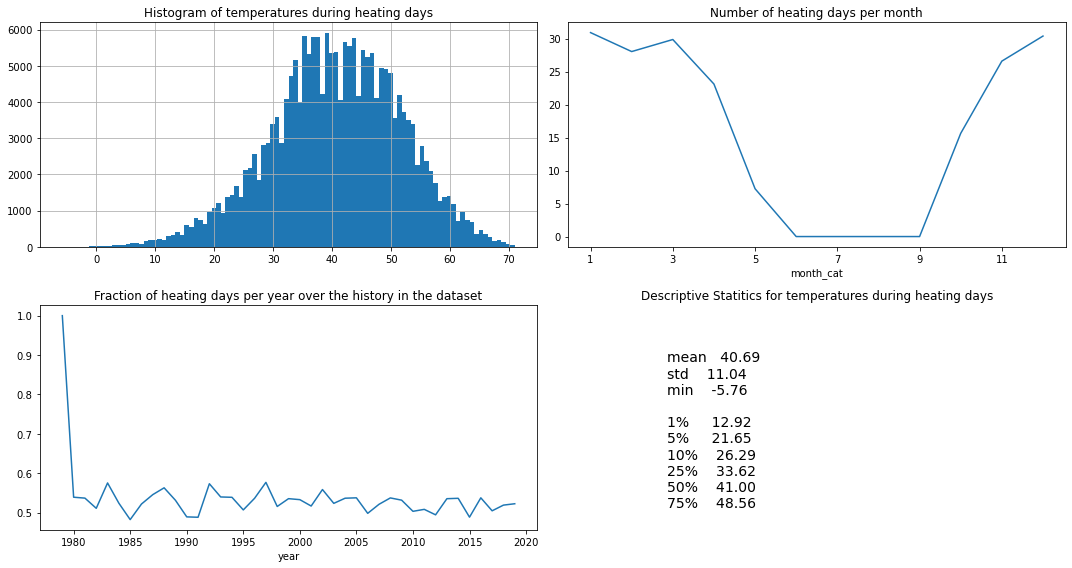

In [3]:
fig,axes=plt.subplots(2,2,figsize=(15,8))
axes=axes.reshape(-1)
heating_day['temp'].hist(bins=100,ax=axes[0])
axes[0].set_title('Histogram of temperatures during heating days')
axes[1].set_title('Number of heating days per month')
(heating_day.drop_duplicates(subset=['date']).groupby('month_cat')['date'].nunique()/40.0).plot(ax=axes[1])
axes[2].set_title('Fraction of heating days per year over the history in the dataset')
weather.groupby('year')['is_heating_day'].mean().plot(ax=axes[2])
desc=heating_day['temp'].describe(percentiles=[.01,.05,.10,.25,.50,.75])[['mean', 'std', 'min', '1%', '5%', '10%', '25%', '50%', '75%']]
_= axes[3].text(.20,.1,desc.to_string(float_format='%.2f').replace('\n','\n\n',3).replace('\n\n','\n',2),fontsize=14)
axes[3].get_xaxis().set_visible(False)
axes[3].get_yaxis().set_visible(False)
_ = axes[3].axis('off')
_ = axes[3].set_title('Descriptive Statitics for temperatures during heating days')
fig.tight_layout()

### Cooling Days

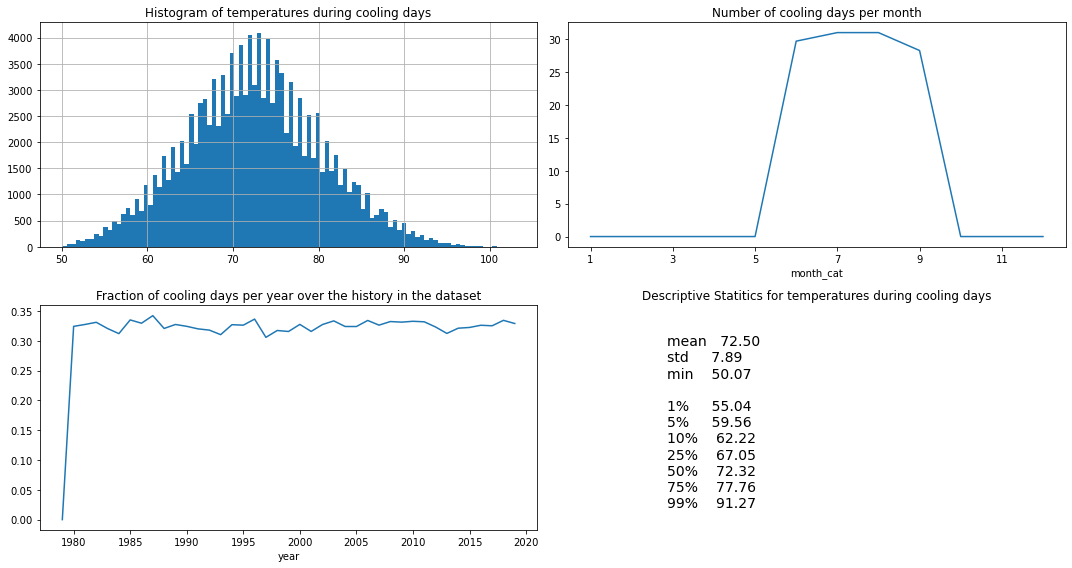

In [4]:
fig,axes=plt.subplots(2,2,figsize=(15,8))
axes=axes.reshape(-1)
cooling_day['temp'].hist(bins=100,ax=axes[0])
axes[0].set_title('Histogram of temperatures during cooling days')
axes[1].set_title('Number of cooling days per month')
(cooling_day.drop_duplicates(subset=['date']).groupby('month_cat')['date'].nunique()/40.0).plot(ax=axes[1])
axes[2].set_title('Fraction of cooling days per year over the history in the dataset')
weather.groupby('year')['is_cooling_day'].mean().plot(ax=axes[2])
desc=cooling_day['temp'].describe(percentiles=[.01,.05,.10,.25,.50,.75,.99])[['mean', 'std', 'min', '1%', '5%', '10%', '25%', '50%', '75%','99%']]
_= axes[3].text(.20,.1,desc.to_string(float_format='%.2f').replace('\n','\n\n',3).replace('\n\n','\n',2),fontsize=14)
axes[3].get_xaxis().set_visible(False)
axes[3].get_yaxis().set_visible(False)
_ = axes[3].axis('off')
_ = axes[3].set_title('Descriptive Statitics for temperatures during cooling days')
fig.tight_layout()

### Build the design conditions

In [5]:
design_load=60000 # BTUS/hr
design_outdoor_temp=int(desc['1%']) # ~13 Degrees
design_indoor_temp=70 #degree F
design_supply_temp=120 #degree F
design_dt=design_indoor_temp-design_outdoor_temp #difference between indoor and outdoor on "coldest" hour of the year

#### Build the temperature bin data.

In [6]:
bin_data=heating_day.groupby(['year','outside_temp'])['dt'].nunique().unstack(0).fillna(0).mean(axis=1).to_frame('num_hours').reset_index()

In [16]:
#Current design delta-t
bin_data['dt']=(design_indoor_temp-bin_data['outside_temp'])
#Fraction of the design load
bin_data['pct_of_design_load']=(bin_data['dt'])/design_dt
# Load at this outdoor temp
bin_data['load']=bin_data['pct_of_design_load']*design_load
# Ignore scenarios below or above design conditions
bin_data=bin_data.query('(pct_of_design_load>=0)&(pct_of_design_load<=1)').copy()
#Number of hours at or above the current load and by %
bin_data['num_hours_at_or_above_load']=bin_data.sort_values(by='pct_of_design_load',ascending=False)['num_hours'].cumsum()
bin_data['pct_time_at_or_above_load']=bin_data['num_hours_at_or_above_load']/(bin_data['num_hours_at_or_above_load'].max())

#Building load function
building_load = lambda outside_temp: ((design_indoor_temp-outside_temp)/design_dt)*design_load

#Supply Water temperature as a function of load and design max temp, max temp setting requires 
# consulting radiator design/manual-J
swt_slope=(design_supply_temp-design_indoor_temp)/design_dt
swt = lambda x: swt_slope*(design_indoor_temp-x) + design_indoor_temp
swt_intercept=swt(0)

#from SWT -> outdoor temp
swtinv = lambda swt: (design_indoor_temp-swt)*design_dt/(design_supply_temp-design_indoor_temp) + design_indoor_temp

#SSI Capacity and COP courtesy of John Seigenthaler
bin_data['SWT']=bin_data['outside_temp'].apply(swt)
b1 = lambda ts: .047865-.000259098*ts
b2 = lambda ts: 5.505128e-5 - 9.0026e-7*ts + (3.9629e-9)*ts**2
COP = lambda tout: (4.82-.026*swt(tout)) + b1(swt(tout))*tout + b2(swt(tout))*tout**2
q = lambda tout: (56518-100.6385*swt(tout))  + (709.32-1.26291*swt(tout))*tout
bin_data['SSI_output']=bin_data[['SWT','outside_temp']].apply(lambda row: min(q(row['outside_temp']),65000),axis=1)
bin_data['SSI_COP']=bin_data[['SWT','outside_temp']].apply(lambda row: min(COP(row['outside_temp']),4.5),axis=1)

#Automatically compute the balance point where SSI output matches the building load
fmin = lambda x: np.abs(q(x)-building_load(x))
res=minimize_scalar(fmin,bounds=(0,design_indoor_temp), method='bounded')
balance_point=res.x
print(res)

     fun: 0.0016690023185219616
 message: 'Solution found.'
    nfev: 23
  status: 0
 success: True
       x: 52.04267678603498


In [8]:
official_sis_table=pd.read_csv('./data/sis_060a.csv')
official_sis_table['Capacity']=official_sis_table['Capacity'].str.replace(',','').astype(float)
official_sis_table.loc[official_sis_table['Water Temp']<=60,'COP']/=3.412

In [9]:
cooling_model=official_sis_table.loc[official_sis_table['Water Temp']<=60].query('Frequency==30')

In [10]:
cooling_bin_data=cooling_day.groupby(['year','outside_temp'])['dt'].nunique().unstack(0).fillna(0).mean(axis=1).to_frame('num_hours').reset_index()

In [11]:
design_cooling_load=36000 # BTUS/hr
design_cooling_outdoor_temp=95# ~90 Degrees
design_cooling_indoor_temp=74 #degree F
design_cooling_supply_temp=48 #degree F
design_cooling_dt=design_cooling_outdoor_temp-design_cooling_indoor_temp #difference between indoor and outdoor on "coldest" hour of the year

In [12]:
#Current design delta-t
cooling_bin_data['dt']=(cooling_bin_data['outside_temp']-design_cooling_indoor_temp)
cooling_day['dt']=(cooling_day['outside_temp']-design_cooling_indoor_temp).clip(lower=0).replace(0,np.nan)

#Fraction of the design load
cooling_bin_data['pct_of_design_load']=(cooling_bin_data['dt'])/design_cooling_dt
cooling_day['pct_of_design_load']=((cooling_day['dt'])/design_cooling_dt).clip(lower=0)
# Load at this outdoor temp
cooling_bin_data['load']=cooling_bin_data['pct_of_design_load']*design_cooling_load
cooling_day['load']=(cooling_day['pct_of_design_load'])*design_cooling_load
# Ignore scenarios below or above design conditions
cooling_bin_data=cooling_bin_data.query('(pct_of_design_load>0)&(pct_of_design_load<=1)').copy()
#Number of hours at or above the current load and by %
cooling_bin_data['num_hours_at_or_above_load']=cooling_bin_data.sort_values(by='pct_of_design_load',ascending=False)['num_hours'].cumsum()
cooling_bin_data['pct_time_at_or_above_load']=cooling_bin_data['num_hours_at_or_above_load']/(cooling_bin_data['num_hours_at_or_above_load'].max())

<AxesSubplot:>

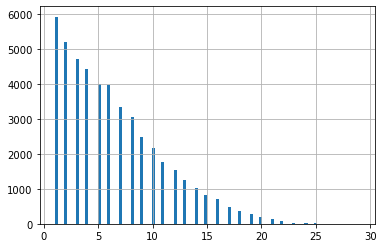

In [13]:
cooling_day['dt'].hist(bins=100)

<AxesSubplot:xlabel='time'>

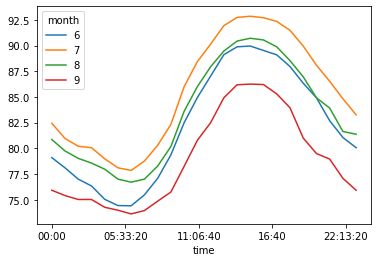

In [14]:
cooling_day.groupby(['month','time'])['temp'].quantile(.95).unstack(0).plot()

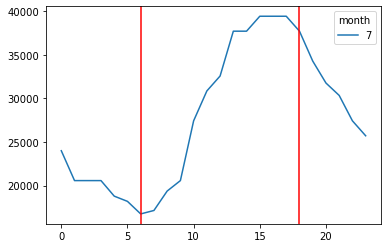

In [18]:
avg_loads_hottest_month=cooling_day.query('month==7').groupby(['month','time'])['load'].quantile(.99).unstack(0)
avg_loads_hottest_month.index=pd.Series(avg_loads_hottest_month.index.values).apply(lambda t: t.hour)
tmin = avg_loads_hottest_month.idxmin().values
tmax = avg_loads_hottest_month.idxmin().values
ax=avg_loads_hottest_month.plot()
ax.axvline(6,color='r')
ax.axvline(18,color='r')

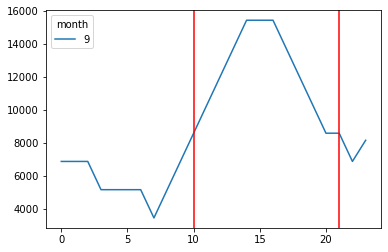

In [20]:
avg_loads_hottest_month=cooling_day.query('month==9').groupby(['month','time'])['load'].quantile(.75).unstack(0)
avg_loads_hottest_month.index=pd.Series(avg_loads_hottest_month.index.values).apply(lambda t: t.hour)
tmin = avg_loads_hottest_month.idxmin().values
tmax = avg_loads_hottest_month.idxmin().values
ax=avg_loads_hottest_month.plot()
ax.axvline(10,color='r')
ax.axvline(21,color='r')

In [21]:
#Building load function
building_cooling_load = lambda outside_temp: ((outside_temp-design_cooling_indoor_temp)/design_cooling_dt)*design_cooling_load

#Supply Water temperature as a function of load and design max temp, max temp setting requires 
# consulting radiator design/manual-J
swt_cooling_slope=(design_cooling_supply_temp-design_cooling_indoor_temp)/design_cooling_dt
cooling_swt = lambda x: min(swt_cooling_slope*(x-design_cooling_indoor_temp) + design_cooling_indoor_temp,60)
cooling_swt_intercept=cooling_swt(0)

#SSI Capacity and COP courtesy of John Seigenthaler
cooling_bin_data['SWT']=cooling_bin_data['outside_temp'].apply(cooling_swt)

In [254]:
LN=np.log
EXP=np.exp
condition_one = lambda RH, TlC, TaC,TrC: ((237.3*LN((RH*EXP(17.27*(TlC/(TlC+237.3))))))/(17.27-LN((RH*EXP(17.27*(TlC/(TlC+237.3))))))<((TaC+TrC)/2))
condition_two = lambda RH, TlC, TaC,TrC,U_C: (1/(1+((2258*((0.622/((101325/(1*611*EXP(17.27*(((TaC+TrC)/2)/(((TaC+TrC)/2)+237.3))))))-1)*1000-(0.622/((101325/(RH*611*EXP(17.27*(TlC/(TlC+237.3))))))-1)*1000))/(1005*(((TaC+TrC)/2)-TlC))))*1.039+((-0.000729*U_C+0.001448)*(TlC-((TaC+TrC)/2))+(0.016908*U_C-0.033574))*1.039>1)
def divisor(RH,TlC,TaC,TrC,U_C):
        if condition_one(RH,TlC,TaC,TrC):
                return 1
        elif condition_two(RH,TlC,TaC,TrC,U_C):
                return 1
        else:
                exp_term=EXP(17.27*(((TaC+TrC)/2)/(((TaC+TrC)/2)+237.3)))
                return 1/(1+((2258*((0.622/((101325/(1*611*EXP(17.27*(((TaC+TrC)/2)/(((TaC+TrC)/2)+237.3))))))-1)*1000-(0.622/((101325/(RH*611*EXP(17.27*(TlC/(TlC+237.3))))))-1)*1000))/(1005*(((TaC+TrC)/2)-TlC))))*1.039+((-0.000729*U_C+0.001448)*(TlC-((TaC+TrC)/2))+(0.016908*U_C-0.033574))*1.039

def total_cooling_load(EnteringT,LeavingT,AirT,RH,Altitude=1):

    f2c=lambda x: (x-32)/1.8
    TaC=f2c(EnteringT) #Entering T in C
    TrC=f2c(LeavingT) #Leaving T in C
    TlC=f2c(AirT) # Air Temp in C
    U_C=lambda FanSpeed: FanSpeed/10
    N_c=1 #For all Briza12 
    cooling_load = lambda sensible,fanspeed: ((sensible/3.412141633)/divisor(RH,TlC,TaC,TrC,U_C(fanspeed)))*3.412141633
    briza_base_sensible=pd.DataFrame(np.asarray([[615,513,433,368,327],
    [766,644,544,410,395],
    [920,823,709,594,508],
    [1149,1022,890,746,627]]),
    columns=[100,80,60,40,20],
    index=['BZBC.03810200','BZBC.03812200','BZBC.05210200','BZBC.05212200'])
    briza_capacity=briza_base_sensible*(((TlC-((TaC+TrC)/2))/10)**N_c)*3.412141633*Altitude
    briza_capacity=briza_capacity.stack().reset_index(level=1).rename(columns={'level_1':'fanspeed',0:'sensible'})
    briza_capacity['total_capacity']=briza_capacity.apply(lambda row: cooling_load(row['sensible'], row['fanspeed']),axis=1)
    briza_capacity['latent']=(briza_capacity['total_capacity']-briza_capacity['sensible'])
    briza_capacity['EnteringT']=round(EnteringT,2)
    briza_capacity['LeavingT']=round(LeavingT,2)
    briza_capacity['AirT']=AirT
    return briza_capacity

In [255]:
capacity_estimates=pd.concat([total_cooling_load(ent,ent-2/5*ent + 28,75,.5) for ent in np.arange(45,75,.5)]).reset_index().rename(columns={'index':'model'})

In [285]:
dct={'Family Room': [3192,356],
'Kitchen': [1889,541],
'Living Room': [10038/2.0,1631.5/2.0],
'Living Room2': [10038/2.0,1631.5/2.0],
'Office': [1237,428],
'Turtle Room': [1985,518],
'Guest Bedroom': [2323,548],
'Master Bedroom': [7246.5,789],
'Perls Bedroom': [1533,234]}
loads=pd.DataFrame.from_dict(data=dct,orient='index',columns=['sensible','latent']).reset_index().rename(columns={'index':'fancoil'})
loads['total']=loads['sensible']+loads['latent']

In [287]:
capacity_estimates['key']=1
loads['key']=1
merged=loads.merge(capacity_estimates,
            how='outer',
            on='key',
            suffixes=['_load','_capacity']).query('(.75*sensible_load <= sensible_capacity)&(.75*latent_load<=latent_capacity)')
merged['error']=(merged['total_capacity']-merged['total'])
merged['right_sizedness']=(merged['total_capacity']-merged['total']).abs()
del merged['key']
merged.loc[merged.groupby(['fancoil']).right_sizedness.idxmin()]

,fancoil,sensible_load,latent_load,total,model,fanspeed,sensible_capacity,total_capacity,latent_capacity,EnteringT,LeavingT,AirT,error,right_sizedness
19,Family Room,3192.0,356.00,3548.00,BZBC.05212200,20,2971.406672,3581.205672,609.799000,45.0,55.0,75,33.205672,33.205672
7214,Guest Bedroom,2323.0,548.00,2871.00,BZBC.05210200,20,2407.455486,2901.519109,494.063623,45.0,55.0,75,30.519109,30.519109
1254,Kitchen,1889.0,541.00,2430.00,BZBC.05210200,20,2330.416910,2742.098863,411.681953,46.0,55.6,75,312.098863,312.098863
2435,Living Room,5019.0,815.75,5834.75,BZBC.05212200,100,5358.086006,5972.315937,614.229930,45.5,55.3,75,137.565937,137.565937
3635,Living Room2,5019.0,815.75,5834.75,BZBC.05212200,100,5358.086006,5972.315937,614.229930,45.5,55.3,75,137.565937,137.565937
8415,Master Bedroom,7246.5,789.00,8035.50,BZBC.05212200,100,5445.209356,6145.122001,699.912645,45.0,55.0,75,-1890.377999,1890.377999
4803,Office,1237.0,428.00,1665.00,BZBC.03810200,40,1743.983501,2066.778057,322.794556,45.0,55.0,75,401.778057,401.778057
9644,Perls Bedroom,1533.0,234.00,1767.00,BZBC.03810200,20,1500.091200,1765.091197,264.999997,46.0,55.6,75,-1.908803,1.908803
6054,Turtle Room,1985.0,518.00,2503.00,BZBC.05210200,20,2330.416910,2742.098863,411.681953,46.0,55.6,75,239.098863,239.098863


In [ ]:
x=cooling_model['Water Temp'].unique()
y=cooling_model['Ambient'].unique()
X,Y=np.meshgrid(x,y)
Z=cooling_model['Capacity'].values.reshape(4,2)
interp_cooling_model=RectBivariateSpline(y,x, Z,ky=1)
Z1=cooling_model['kW'].values.reshape(4,2)
interp_cooling_model_energy=RectBivariateSpline(y,x, Z1,ky=1)

In [ ]:
capacity_model=interp2d(cooling_model['Ambient'],cooling_model['Water Temp'],z=cooling_model[['Capacity']],kind='linear')
energy_model=interp2d(cooling_model['Ambient'],cooling_model['Water Temp'],z=cooling_model[['kW']],kind='linear')
#cooling_bin_data['implied_capacity']=cooling_bin_data.apply(lambda row: capacity_model(row['outside_temp'], row['SWT']).item(),axis=1)
#cooling_bin_data['implied_energy']=cooling_bin_data.apply(lambda row: energy_model(row['outside_temp'], row['SWT']).item(),axis=1)

In [ ]:
cooling_bin_data['estimated_capacity']=cooling_bin_data.apply(lambda row: interp_cooling_model(row['outside_temp'],row['SWT']).item(),axis=1)
cooling_bin_data['estimated_kW']=cooling_bin_data.apply(lambda row: interp_cooling_model_energy(row['outside_temp'],row['SWT']).item(),axis=1)
cooling_bin_data['estimated_COP']=(cooling_bin_data['estimated_capacity']/3412)/cooling_bin_data['estimated_kW']

In [ ]:
cooling_bin_data

In [ ]:
ax=bin_data.set_index('outside_temp')[['SSI_COP']].plot()
ax.legend(loc=4)
ax.set_ylabel('Computed COP')
ax=bin_data.set_index('outside_temp')[['SSI_output']].plot(ax=ax.twinx(),color='orange')
ax.set_ylabel('Compute Heat Pump Output')
plt.locator_params(nbins=10)
new_ax=ax.secondary_xaxis('top', functions=(swt,swtinv))
new_ax.set_xlabel('Water Temperature')
_=new_ax.set_xticks((154,140,130,120,110,100,95,90,85,80,75,70))

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Comparison of Time Spent at various building loads compared to SSI capacity')
plt.minorticks_on()
axes=axes.reshape(-1)
ax=axes[0]
bin_data.plot(x='num_hours_at_or_above_load',y='pct_of_design_load',label='% of design load',ax=ax)
bin_data.plot.area(x='num_hours_at_or_above_load',y='pct_of_design_load',color='yellow',alpha=0.5,ax=ax)
ax.set_xlabel('# hours at or above load')
ax.set_ylabel('Current Building load % of design')
ax=axes[1]
bin_data.plot(x='outside_temp',y='load',color='white',ax=ax)
ax.invert_xaxis()
ax1=ax.twinx()
ax1.set_ylabel('Building Load')
bin_data.plot(x='outside_temp',y='SWT',ax=ax1)
ax1.set_ylabel('Supply Water Temperature')
ax1.axvline(design_outdoor_temp,color='r')
bin_data.plot(x='outside_temp',y='SSI_output',ax=ax,style='--',color='g')
fig.suptitle('', fontsize=12,y=1.1)
fig.tight_layout()
axes[0].axhline(1.0,color='r',label='design load')
balance_idx=(bin_data['outside_temp']-balance_point).abs().argmin()
bp_bin=bin_data.iloc[balance_idx]
ax1.axvline(balance_point,color='orange',ls='--')
axes[0].axhline(bp_bin['pct_of_design_load'].item(),ls='--',color='black')
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
below_balance=100*(1-bp_bin['pct_time_at_or_above_load'].item())
# place a text box in upper left in axes coords
_ = axes[0].text(0.1, .25, f'{below_balance:.01f}% of the heat needed \n below the balance point', 
             transform=axes[0].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

#### These systems still provide considerable heat in this design when temperatures drop below the balance point, the COP > 1
#### It's far more efficient than a gas boiler, with a COP typically between .6-.9 at these conditions

In [ ]:
pd.Series([100*q(design_outdoor_temp)/building_load(design_outdoor_temp), 
swt(design_outdoor_temp), 
COP(design_outdoor_temp)],index=['Percentage of heat supplied by SSI @ Design Temp',
                                 'Design water temperature','COP at design'])

### This is the average COP above our balance point

In [ ]:
np.average(bin_data.query('outside_temp>=@balance_point')['SSI_COP'], 
           weights=bin_data.query('outside_temp>=@balance_point')['num_hours'])

### This is the energy delivered in each outdfoor temperature bin, and the energy required

In [ ]:
bin_data['btus_in_bin']=bin_data['load']*bin_data['num_hours']
bin_data['kwh_in_bin']=(bin_data['btus_in_bin']*0.000293071)
bin_data['kwh_required']=(bin_data['kwh_in_bin']/bin_data['SSI_COP'])
bin_data['therms_in_bin']=(bin_data['btus_in_bin']/99976)

In [ ]:
def custom_round(x, base=5):
    return int(base * round(float(x)/base))
bin_data['round_outside_temp']=bin_data['outside_temp'].apply(custom_round)
bin_data['round_ssi_cop']=(10*bin_data['SSI_COP']).apply(custom_round)/10

### Shows the disparity of heating energy delivered in KWH versus heating energy consumed by the heat pump

In [ ]:
bin_data.groupby('round_outside_temp')[['kwh_required','kwh_in_bin']].sum().plot.bar(stacked=True)

In [ ]:
bin_data['above_balance']=(bin_data['outside_temp']>=balance_point)

In [ ]:
energy_del_vs_required = bin_data.groupby('above_balance')[['kwh_in_bin','kwh_required']].sum()

### Serious reductions of total energy needed from the energy grid.
### 67% reduction above the balance point.
### 50% reduction below it

In [ ]:
100*(1-energy_del_vs_required['kwh_required']/energy_del_vs_required['kwh_in_bin'])

### Remaining fraction of total energy from supplemental heat source.

In [ ]:
supplemental=100*(energy_del_vs_required['kwh_in_bin'][False]/(energy_del_vs_required['kwh_in_bin'][False]+energy_del_vs_required['kwh_in_bin'][True]))
f'{round(supplemental,2)}% from supplemental heat source'

### Total % reduction in energy from grid

In [ ]:
from_grid=100*(energy_del_vs_required['kwh_required'].sum()/energy_del_vs_required['kwh_in_bin'].sum())
f'{round(from_grid,2)}% electricity from grid'

### Cost Savings % including dollars

In [ ]:
round(100*(1-round((energy_del_vs_required['kwh_required'].sum())*.25,2)/round((energy_del_vs_required['kwh_in_bin'].sum()/(.9*29.3001))*2.50,2)),2)

### Cost Savings % including dollars

In [ ]:
round(100*(1-((energy_del_vs_required['kwh_required'].sum()-2000)*.25)/(energy_del_vs_required['kwh_in_bin'].sum()/((.8*29.3001))*2.50)),2)

### # of hours at each COP above the balance point

In [ ]:
bin_data.query('outside_temp>=@balance_point').groupby('round_ssi_cop')['num_hours'].sum().plot.bar()

In [ ]:
def weighted_median(df, val, weight):
    df_sorted = df.sort_values(val)
    cumsum = df_sorted[weight].cumsum()
    cutoff = df_sorted[weight].sum() / 2.
    return df_sorted[cumsum >= cutoff][val].iloc[0]

In [ ]:
weighted_median(bin_data,'SSI_COP','num_hours')